# Text Analysis on NYTimes Articles about 2020 primary election

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Text-Analysis-on-NYTimes-Articles-about-2020-primary-election" data-toc-modified-id="Text-Analysis-on-NYTimes-Articles-about-2020-primary-election-1">Text Analysis on NYTimes Articles about 2020 primary election</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data-for-Analysis" data-toc-modified-id="Prepare-Data-for-Analysis-1.1">Prepare Data for Analysis</a></span><ul class="toc-item"><li><span><a href="#Get-the-data-into-a-data-frame-before-pre-processing" data-toc-modified-id="Get-the-data-into-a-data-frame-before-pre-processing-1.1.1">Get the data into a data frame before pre-processing</a></span></li><li><span><a href="#Convert-all-words-to-lowercase,-handle-negation,-and-remove-all-stop-words-and-punctuation." data-toc-modified-id="Convert-all-words-to-lowercase,-handle-negation,-and-remove-all-stop-words-and-punctuation.-1.1.2">Convert all words to lowercase, handle negation, and remove all stop words and punctuation.</a></span></li><li><span><a href="#Stem-words-using-Porter-1979" data-toc-modified-id="Stem-words-using-Porter-1979-1.1.3">Stem words using Porter 1979</a></span></li></ul></li><li><span><a href="#Create-Bag-Of-Words-(BOW)-vector,-and-vectorize-each-article" data-toc-modified-id="Create-Bag-Of-Words-(BOW)-vector,-and-vectorize-each-article-1.2">Create Bag-Of-Words (BOW) vector, and vectorize each article</a></span></li><li><span><a href="#Topic-Modeling" data-toc-modified-id="Topic-Modeling-1.3">Topic Modeling</a></span></li><li><span><a href="#Number-of-Candidate-Mentions-in-Each-Article" data-toc-modified-id="Number-of-Candidate-Mentions-in-Each-Article-1.4">Number of Candidate Mentions in Each Article</a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-1.5">Sentiment Analysis</a></span></li></ul></li></ul></div>

In [143]:
import pandas as pd
import numpy as np
import json
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import multiprocessing as mp
import re
from nltk.probability import FreqDist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation as LDA

## Prepare Data for Analysis

### Get the data into a data frame before pre-processing 

In [73]:
#load the data into a dataframe
with open('feb_dict.json', encoding="UTF-8") as json_feb:
    data = json.load(json_feb)
    json_feb.close
    
feb_data = pd.DataFrame.from_dict(data, orient='index')
    

In [74]:
feb_data.head()

,0
10,Before the first votes are cast in the Democra...
11,"DES MOINES — Once upon a time, the winner of t..."
12,"SIOUX CITY, Iowa — After a long campaign of id..."
13,"CENTERVILLE, Iowa — Jill Biden was torn. Three..."
22,"DES MOINES — For a full year, Democrats owned ..."


In [75]:
feb_data = feb_data.reset_index()

In [76]:
feb_data.columns = ['article_index','article_text']

In [84]:
feb_data['article_index'] = feb_data.apply(lambda x: str(x['article_index'])+"f", axis=1)


In [85]:
feb_data.head()

,article_index,article_text
0,10f,Before the first votes are cast in the Democra...
1,11f,"DES MOINES — Once upon a time, the winner of t..."
2,12f,"SIOUX CITY, Iowa — After a long campaign of id..."
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three..."
4,22f,"DES MOINES — For a full year, Democrats owned ..."


In [86]:
#load the march data into a dataframe
with open('march_dict.json', encoding="UTF-8") as json_march:
    data = json.load(json_march)
    json_march.close
    
march_data = pd.DataFrame.from_dict(data, orient='index')

In [87]:
march_data.head()

,0
10,"There was no drama this time, and no delay: Wi..."
17,WASHINGTON — The Supreme Court agreed on Monda...
18,"To the Editor: Re “No, Not Sanders, Not Ever,”..."
22,To the Editor: Re “Democratic Race Resets as B...
24,WASHINGTON — President Trump returned on Monda...


In [89]:
march_data = march_data.reset_index()

In [90]:
march_data.columns = ['article_index','article_text']

In [91]:
march_data['article_index'] = march_data.apply(lambda x: str(x['article_index'])+"m", axis=1)


In [92]:
all_articles = feb_data.append(march_data)

In [93]:
all_articles = all_articles.reset_index(drop=True)

In [94]:
all_articles.head()

,article_index,article_text
0,10f,Before the first votes are cast in the Democra...
1,11f,"DES MOINES — Once upon a time, the winner of t..."
2,12f,"SIOUX CITY, Iowa — After a long campaign of id..."
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three..."
4,22f,"DES MOINES — For a full year, Democrats owned ..."


### Convert all words to lowercase, handle negation, and remove all stop words and punctuation.

In [95]:
def text_preprocess(raw_text):
    """
    text preprocess function that convert input text to lower case, split negation with "n't" into "not",
    remove stop words and punctuations, and finally combine "not" into the next word.
    """
    # convert to lower case
    temp = raw_text.lower()
    
    # split n't from negation words.
    temp = re.sub("n't", " not", temp.strip())
    
    # tokenize only the words
    tokenizer = RegexpTokenizer(r'\w+')
    temp = tokenizer.tokenize(temp)
    
    # remove stop words using existing NLTK library 
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    temp = [w for w in temp if not w in stop_words]
    
    # negation handling
    def neg_tag(tk):
        tbpoped = []
        for index, w in enumerate(tk):
            if w == "not":
                if index < len(tk)-1:
                    tbpoped.append(index)
                    tk[index+1]="not_"+tk[index+1]
                    
        tk = [v for i,v in enumerate(tk) if i not in tbpoped]
        return tk
    
    processed_txt = neg_tag(temp)
    
    return processed_txt

In [96]:
# use parallel processing to preprocess text
article_text_list = list(all_articles['article_text'])

cores = mp.cpu_count()
pool = mp.Pool(cores)
txt_rdy = pool.map(text_preprocess, article_text_list)
pool.terminate()
pool.join() 

### Stem words using Porter 1979

In [97]:
def stemming(tk):
    """
    stemming function using Porter 1979 Stemmer. The input is a list of tokenized text.
    """
    ps = PorterStemmer()
    stemmed = []
    for w in tk:
        stemmed.append(ps.stem(w))
    return stemmed

In [98]:
# use parallel processing to stem the words
pool = mp.Pool(cores)
txt_stem = pool.map(stemming, txt_rdy)
pool.terminate()
pool.join() 

In [99]:
articles_stemmed = []
for word_list in txt_stem:
    article = ' '.join([str(word) for word in word_list])
    articles_stemmed.append(article)

In [100]:
all_articles['stemmed'] = pd.Series(articles_stemmed)

In [101]:
all_articles.head()

,article_index,article_text,stemmed
0,10f,Before the first votes are cast in the Democra...,first vote cast democrat presidenti contest ne...
1,11f,"DES MOINES — Once upon a time, the winner of t...",de moin upon time winner iowa caucus obviou ev...
2,12f,"SIOUX CITY, Iowa — After a long campaign of id...",sioux citi iowa long campaign ideolog clash po...
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three...",centervil iowa jill biden torn three month jos...
4,22f,"DES MOINES — For a full year, Democrats owned ...",de moin full year democrat own iowa spotlight ...


In [225]:
len(all_articles)

839

## Create Bag-Of-Words (BOW) vector, and vectorize each article 

In [102]:
# flat list to take all tokens from the review.
flat_list = [token for article_tokens in txt_stem for token in article_tokens]

In [103]:
# find the most frequent 500 words (bag of words)
fdist = FreqDist(flat_list)
most_freq = dict(fdist.most_common(500))

# get the list of actual words
words = []
for key in most_freq:
    words.append(key)

In [104]:
words

['mr',
 'said',
 'democrat',
 'trump',
 'sander',
 'presid',
 'state',
 'campaign',
 'biden',
 'new',
 'candid',
 'would',
 'one',
 'bloomberg',
 'senat',
 'ms',
 'vote',
 'parti',
 'like',
 'support',
 'iowa',
 'year',
 'peopl',
 'time',
 'voter',
 'buttigieg',
 'polit',
 'elect',
 'former',
 'warren',
 'also',
 'first',
 'primari',
 'american',
 'even',
 'two',
 'say',
 'make',
 'last',
 'republican',
 'go',
 'could',
 'day',
 'week',
 'mani',
 'get',
 'race',
 'nation',
 'south',
 'call',
 'report',
 'percent',
 'work',
 'hous',
 'result',
 'poll',
 'tuesday',
 'hampshir',
 'debat',
 'win',
 'show',
 'want',
 'berni',
 'presidenti',
 'think',
 'offici',
 'ad',
 'nevada',
 'countri',
 'mayor',
 'caucus',
 'way',
 'includ',
 'deleg',
 'take',
 'much',
 'tri',
 'nomin',
 'klobuchar',
 'million',
 'right',
 'carolina',
 'black',
 'back',
 'come',
 'run',
 'night',
 'plan',
 'know',
 'white',
 'three',
 'still',
 'made',
 'well',
 'use',
 'month',
 'look',
 'recent',
 'point',
 'york',
 

In [105]:
def vectorize(tks):
    """
    vectorize a list of tokenized words according to the pre-defined BoW. 
    Words appeard in the article is vectorized into 1.
    """
    vector = []
    for w in words:
        if w in tks:
            vector.append(1)
        else:
            vector.append(0)
    return vector

In [106]:
# using parallel processing to vectorize the words for each article
pool = mp.Pool(cores)
word_vec = pool.map(vectorize, txt_stem)
pool.terminate()
pool.join() 

In [107]:
all_articles['word_vec'] = pd.Series(word_vec)

In [108]:
all_articles.head()

,article_index,article_text,stemmed,word_vec
0,10f,Before the first votes are cast in the Democra...,first vote cast democrat presidenti contest ne...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,11f,"DES MOINES — Once upon a time, the winner of t...",de moin upon time winner iowa caucus obviou ev...,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,12f,"SIOUX CITY, Iowa — After a long campaign of id...",sioux citi iowa long campaign ideolog clash po...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three...",centervil iowa jill biden torn three month jos...,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ..."
4,22f,"DES MOINES — For a full year, Democrats owned ...",de moin full year democrat own iowa spotlight ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."


## Topic Modeling

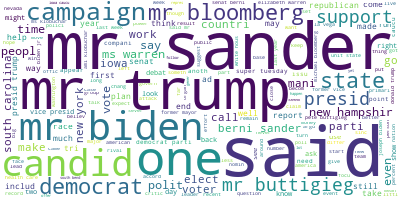

In [167]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ' '.join(list(all_articles['stemmed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import matplotlib.pyplot as plt
total_counts = list(np.zeros(len(words)))

for i in range(len(words)):
    for t in word_vec:
        total_counts[i]+=t[i]

In [169]:
count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]

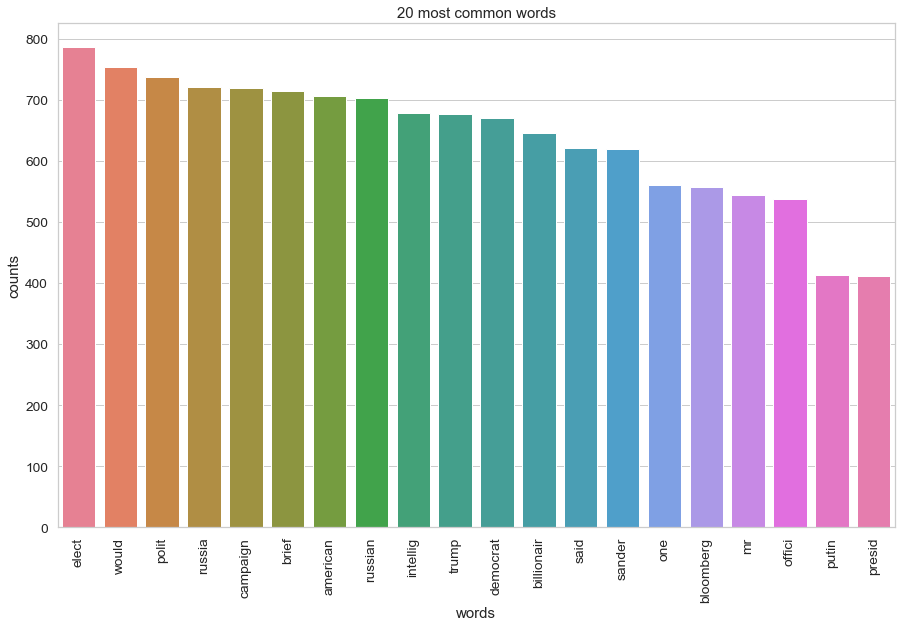

In [170]:
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 
    
plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='20 most common words')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x_pos, counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

In [163]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(all_articles['stemmed'])
words = count_vectorizer.get_feature_names()

n_top_words = 20
n_topics = 10

model = LDA(n_topics)

id_topic = model.fit_transform(count_data)

topic_words = {}

for topic, comp in enumerate(model.components_):
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    # store the words most relevant to the topic
    topic_words[topic] = [words[i] for i in word_idx]

In [164]:
for topic, words in topic_words.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  mr, biden, said, ms, campaign, would, year, senat, owen, one, time, also, work, presid, famili, group, first, lhéritier, compani, includ
Topic: 1
  iowa, result, parti, state, mr, democrat, said, caucus, report, caucu, sander, precinct, deleg, candid, vote, campaign, new, call, buttigieg, offici
Topic: 2
  said, peopl, health, would, viru, coronaviru, compani, trump, mr, presid, year, like, state, new, worker, market, public, american, countri, outbreak
Topic: 3
  said, mr, peopl, like, trump, one, steyer, go, say, want, year, would, right, presid, time, think, first, ms, work, moor
Topic: 4
  mr, sander, biden, democrat, campaign, said, state, voter, buttigieg, candid, ms, support, new, warren, south, iowa, poll, primari, hampshir, former
Topic: 5
  mr, trump, presid, senat, said, republican, impeach, democrat, hous, vote, would, ukrain, investig, trial, state, polit, american, elect, justic, new
Topic: 6
  democrat, trump, candid, sander, said, vote, parti, mr, would, pres

## Number of Candidate Mentions in Each Article

This may not be accurate, since we are using last name to track occurences of Joe Biden, but is a close approximation. Also, mentions of family can also have similar impact to candidate mentions.

In [193]:
biden_counts = []
sanders_counts = []

for article in all_articles['article_text']:
    article = article.lower()
    biden = "biden"
    sanders = "sanders"
    biden_count = article.count(biden)
    sanders_count = article.count(sanders)
    biden_counts.append(biden_count)
    sanders_counts.append(sanders_count)

In [196]:
all_articles['biden_count'] = biden_counts
all_articles['sanders_count'] = sanders_counts

In [200]:
all_articles.loc[all_articles['biden_count'] > all_articles['sanders_count'], 'biden_most'] = 1
all_articles.loc[all_articles['biden_count'] <= all_articles['sanders_count'], 'biden_most'] = 0

all_articles.loc[all_articles['sanders_count'] > all_articles['biden_count'], 'sanders_most'] = 1
all_articles.loc[all_articles['sanders_count'] <= all_articles['biden_count'], 'sanders_most'] = 0



In [201]:
all_articles.head()

,article_index,article_text,stemmed,word_vec,biden_count,sanders_count,polarity,subjectivity,biden_most,sanders_most
0,10f,Before the first votes are cast in the Democra...,first vote cast democrat presidenti contest ne...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1,25,0.055522,0.370515,0.0,1.0
1,11f,"DES MOINES — Once upon a time, the winner of t...",de moin upon time winner iowa caucus obviou ev...,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2,2,0.189676,0.513270,0.0,0.0
2,12f,"SIOUX CITY, Iowa — After a long campaign of id...",sioux citi iowa long campaign ideolog clash po...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",6,11,0.119406,0.394641,0.0,1.0
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three...",centervil iowa jill biden torn three month jos...,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...",55,0,0.121181,0.405113,1.0,0.0
4,22f,"DES MOINES — For a full year, Democrats owned ...",de moin full year democrat own iowa spotlight ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1,1,0.178915,0.428993,0.0,0.0


## Sentiment Analysis

In [173]:
from textblob import TextBlob

In [176]:
index_list = list(range(0,len(all_articles['article_text']),1))
polarity_list = []
subjectivity_list = []

for article in all_articles['article_text']:
    article_blob = TextBlob(article)
    polarity = article_blob.sentiment.polarity
    subjectivity = article_blob.sentiment.subjectivity
    polarity_list.append(polarity)
    subjectivity_list.append(subjectivity)
    

In [191]:
sentiment_df.head()

,polarity,subjectivity
0,0.055522,0.370515
1,0.189676,0.513270
2,0.119406,0.394641
3,0.121181,0.405113
4,0.178915,0.428993


In [198]:
all_articles['polarity'] = polarity_list
all_articles['subjectivity'] = subjectivity_list

In [202]:
all_articles.head()

,article_index,article_text,stemmed,word_vec,biden_count,sanders_count,polarity,subjectivity,biden_most,sanders_most
0,10f,Before the first votes are cast in the Democra...,first vote cast democrat presidenti contest ne...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1,25,0.055522,0.370515,0.0,1.0
1,11f,"DES MOINES — Once upon a time, the winner of t...",de moin upon time winner iowa caucus obviou ev...,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2,2,0.189676,0.513270,0.0,0.0
2,12f,"SIOUX CITY, Iowa — After a long campaign of id...",sioux citi iowa long campaign ideolog clash po...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",6,11,0.119406,0.394641,0.0,1.0
3,13f,"CENTERVILLE, Iowa — Jill Biden was torn. Three...",centervil iowa jill biden torn three month jos...,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...",55,0,0.121181,0.405113,1.0,0.0
4,22f,"DES MOINES — For a full year, Democrats owned ...",de moin full year democrat own iowa spotlight ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1,1,0.178915,0.428993,0.0,0.0


In [204]:
articles_biden_sanders = all_articles[all_articles['biden_count'] != all_articles['sanders_count']]



In [236]:
np.sum(articles_biden_sanders['biden_most'])

209.0

In [237]:
np.sum(articles_biden_sanders['sanders_most'])

515.0

In [233]:
articles_biden_sanders.groupby('biden_most')['polarity'].std()

biden_most
0.0    0.053012
1.0    0.050445
Name: polarity, dtype: float64

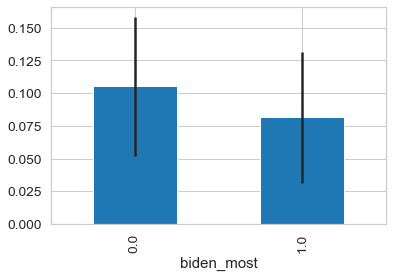

In [231]:
polarity_chart = articles_biden_sanders.groupby('biden_most')['polarity'].mean()
polarity_chart.plot("bar", yerr=[[0.053, 0.050], [0.050, 0.053]])


In [234]:
articles_biden_sanders.groupby('biden_most')['subjectivity'].std()

biden_most
0.0    0.055889
1.0    0.062244
Name: subjectivity, dtype: float64

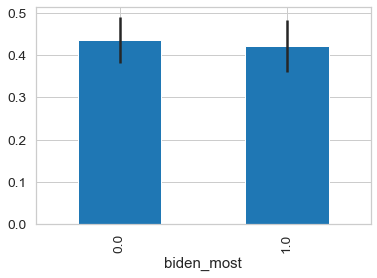

In [235]:
subjectivity_chart = articles_biden_sanders.groupby('biden_most')['subjectivity'].mean()
subjectivity_chart.plot("bar", yerr=[[0.055, 0.062], [0.062, 0.055]])
